# Analysis
Key Analyses
- Daily Total Usage for January
- Daily stacked usage by zip code
- Interval Usage on 28th
- Interval Usage on the 28th, Stack Plot
- Interval Usage, one week

# Load Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./data/results/time_series/chicago_aggregation_final.csv", header=0)

## Load Spatial

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

shapefile_path = "data/spatial/geo_export_86dc231e-3ba9-473c-a7a5-0e89f969d1f6.shp"
gdf = gpd.read_file(shapefile_path)

# convert to 2790
gdf = gdf.to_crs('EPSG:2790')

# compute new square foot areas
gdf['area_2790'] = gdf['geometry'].area

# drop old spatial columns
gdf = gdf.drop(columns = ["shape_area", "shape_len"])

## Total Usage for January

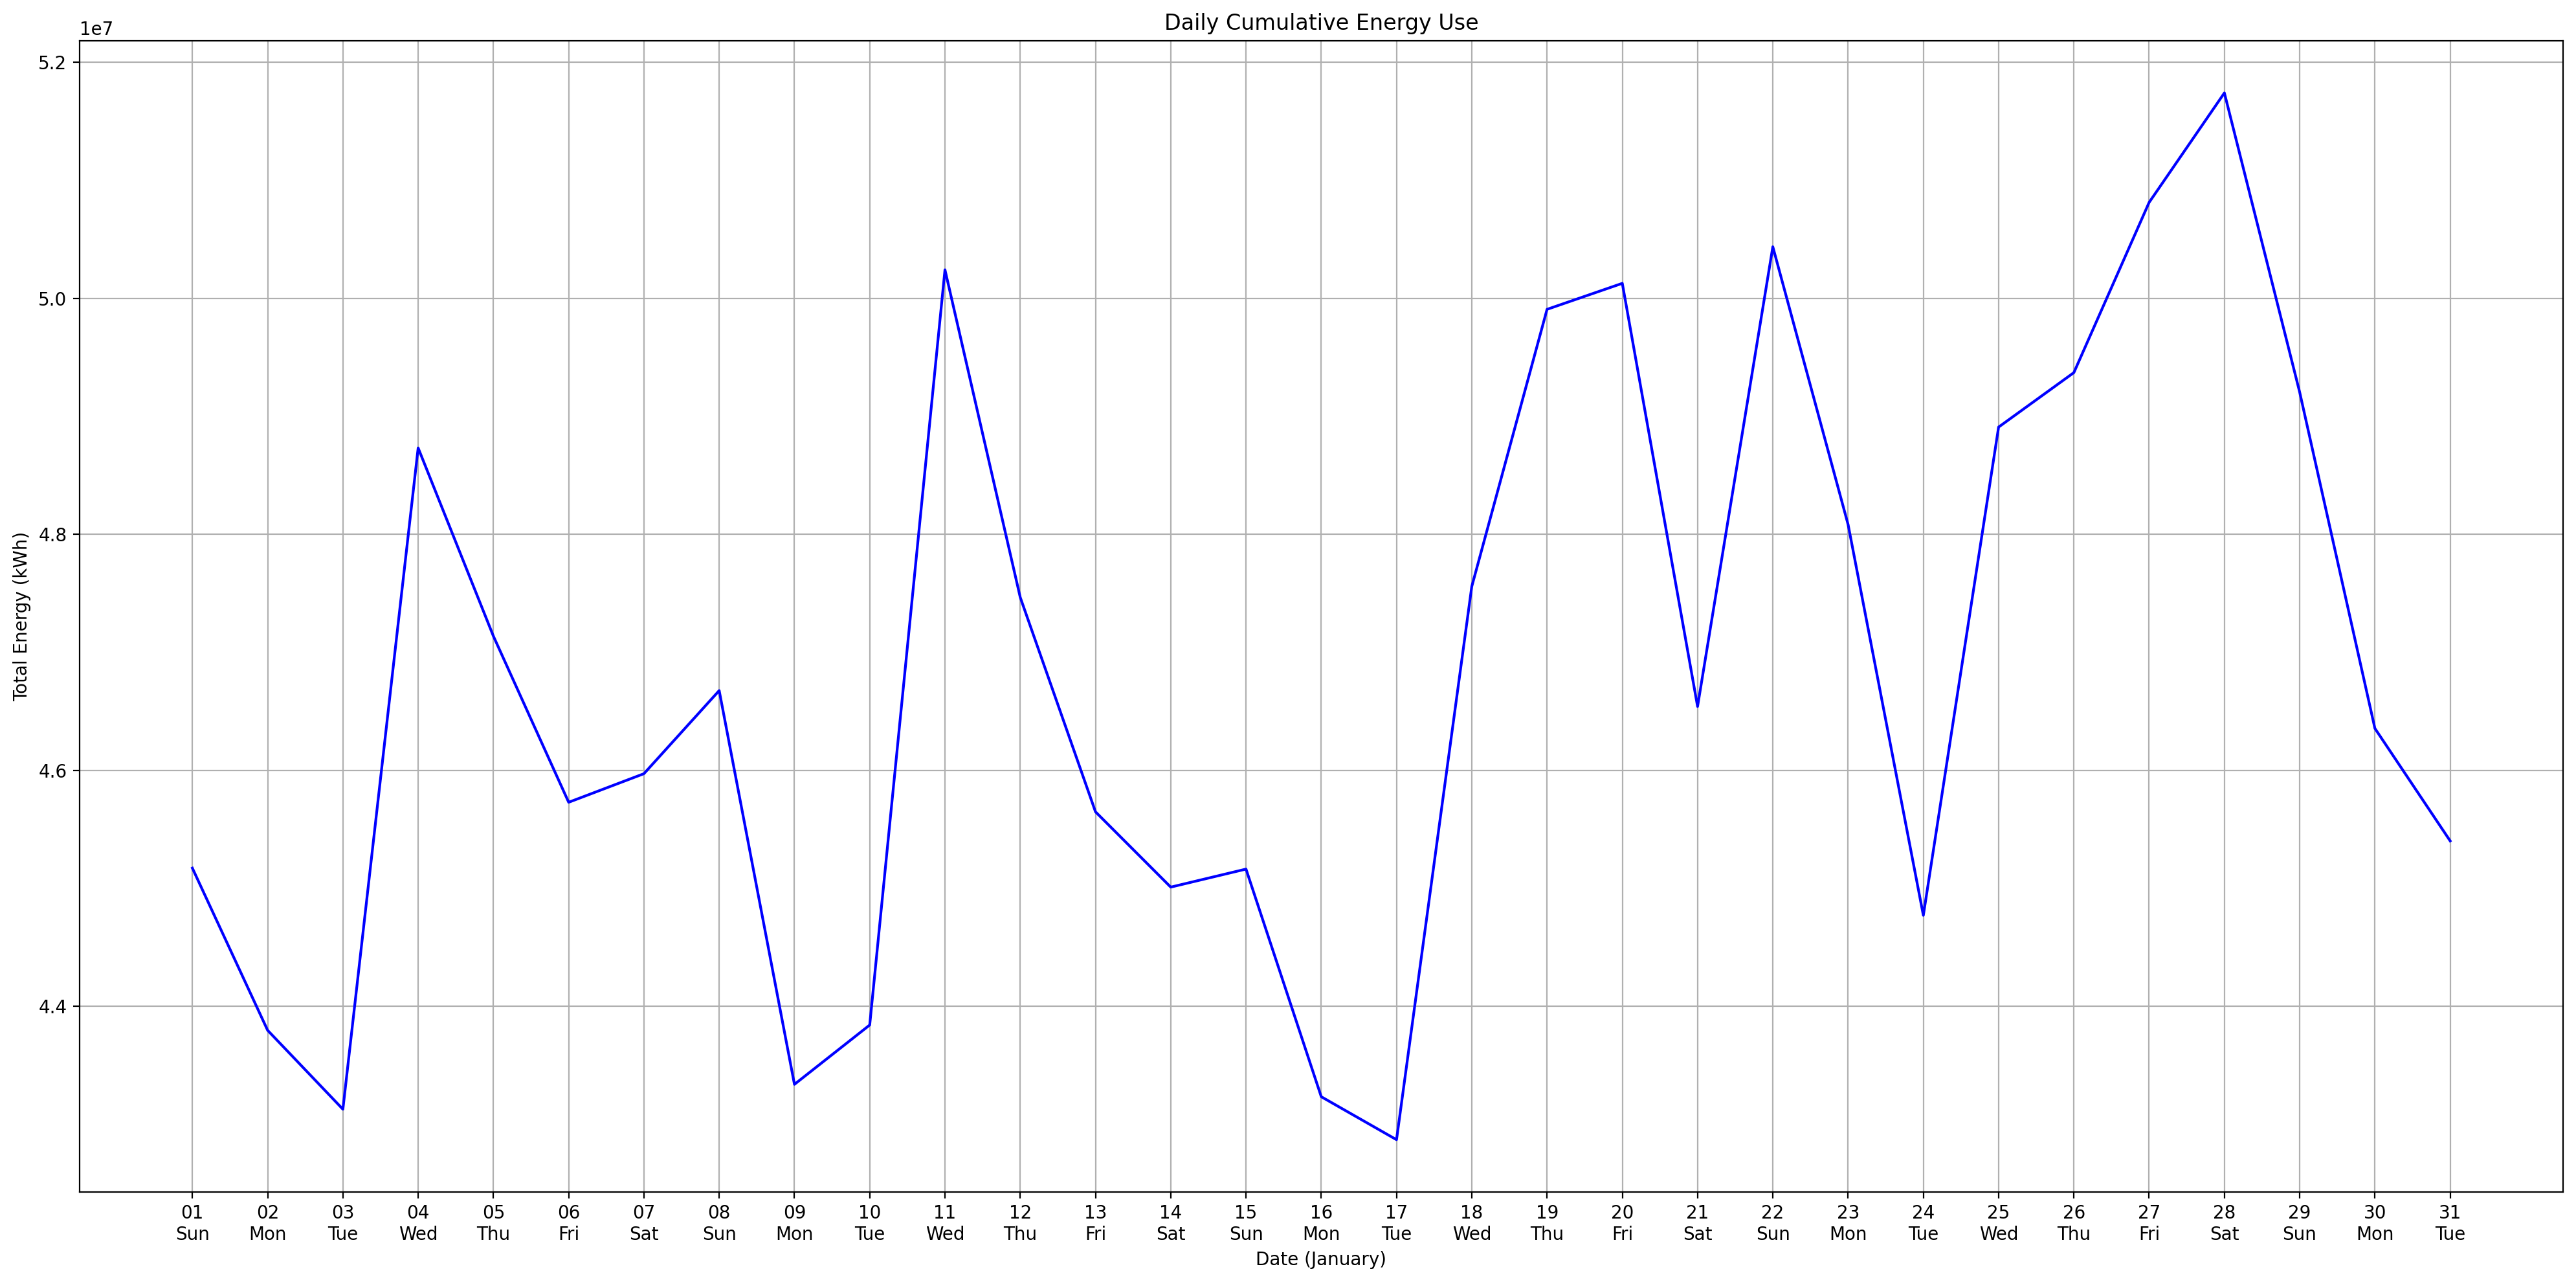

In [3]:
daily_energy_use = df.groupby(["day"])["total_energy"].sum().reset_index()

# Plotting
plt.figure(figsize=(20, 10), dpi = 200)

plt.plot(daily_energy_use['day'], daily_energy_use['total_energy'], linestyle='-', color='b')

plt.xlabel('Date (January)')
plt.ylabel('Total Energy (kWh)')
plt.title('Daily Cumulative Energy Use')
plt.grid(True)

dates = pd.date_range(start='2023-01-01', end='2023-01-31')
plt.xticks(daily_energy_use['day'], [date.strftime('%d\n%a') for date in dates])
#plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

plt.show()

## Daily Usage by Zip Code
### Stacked Line Graph

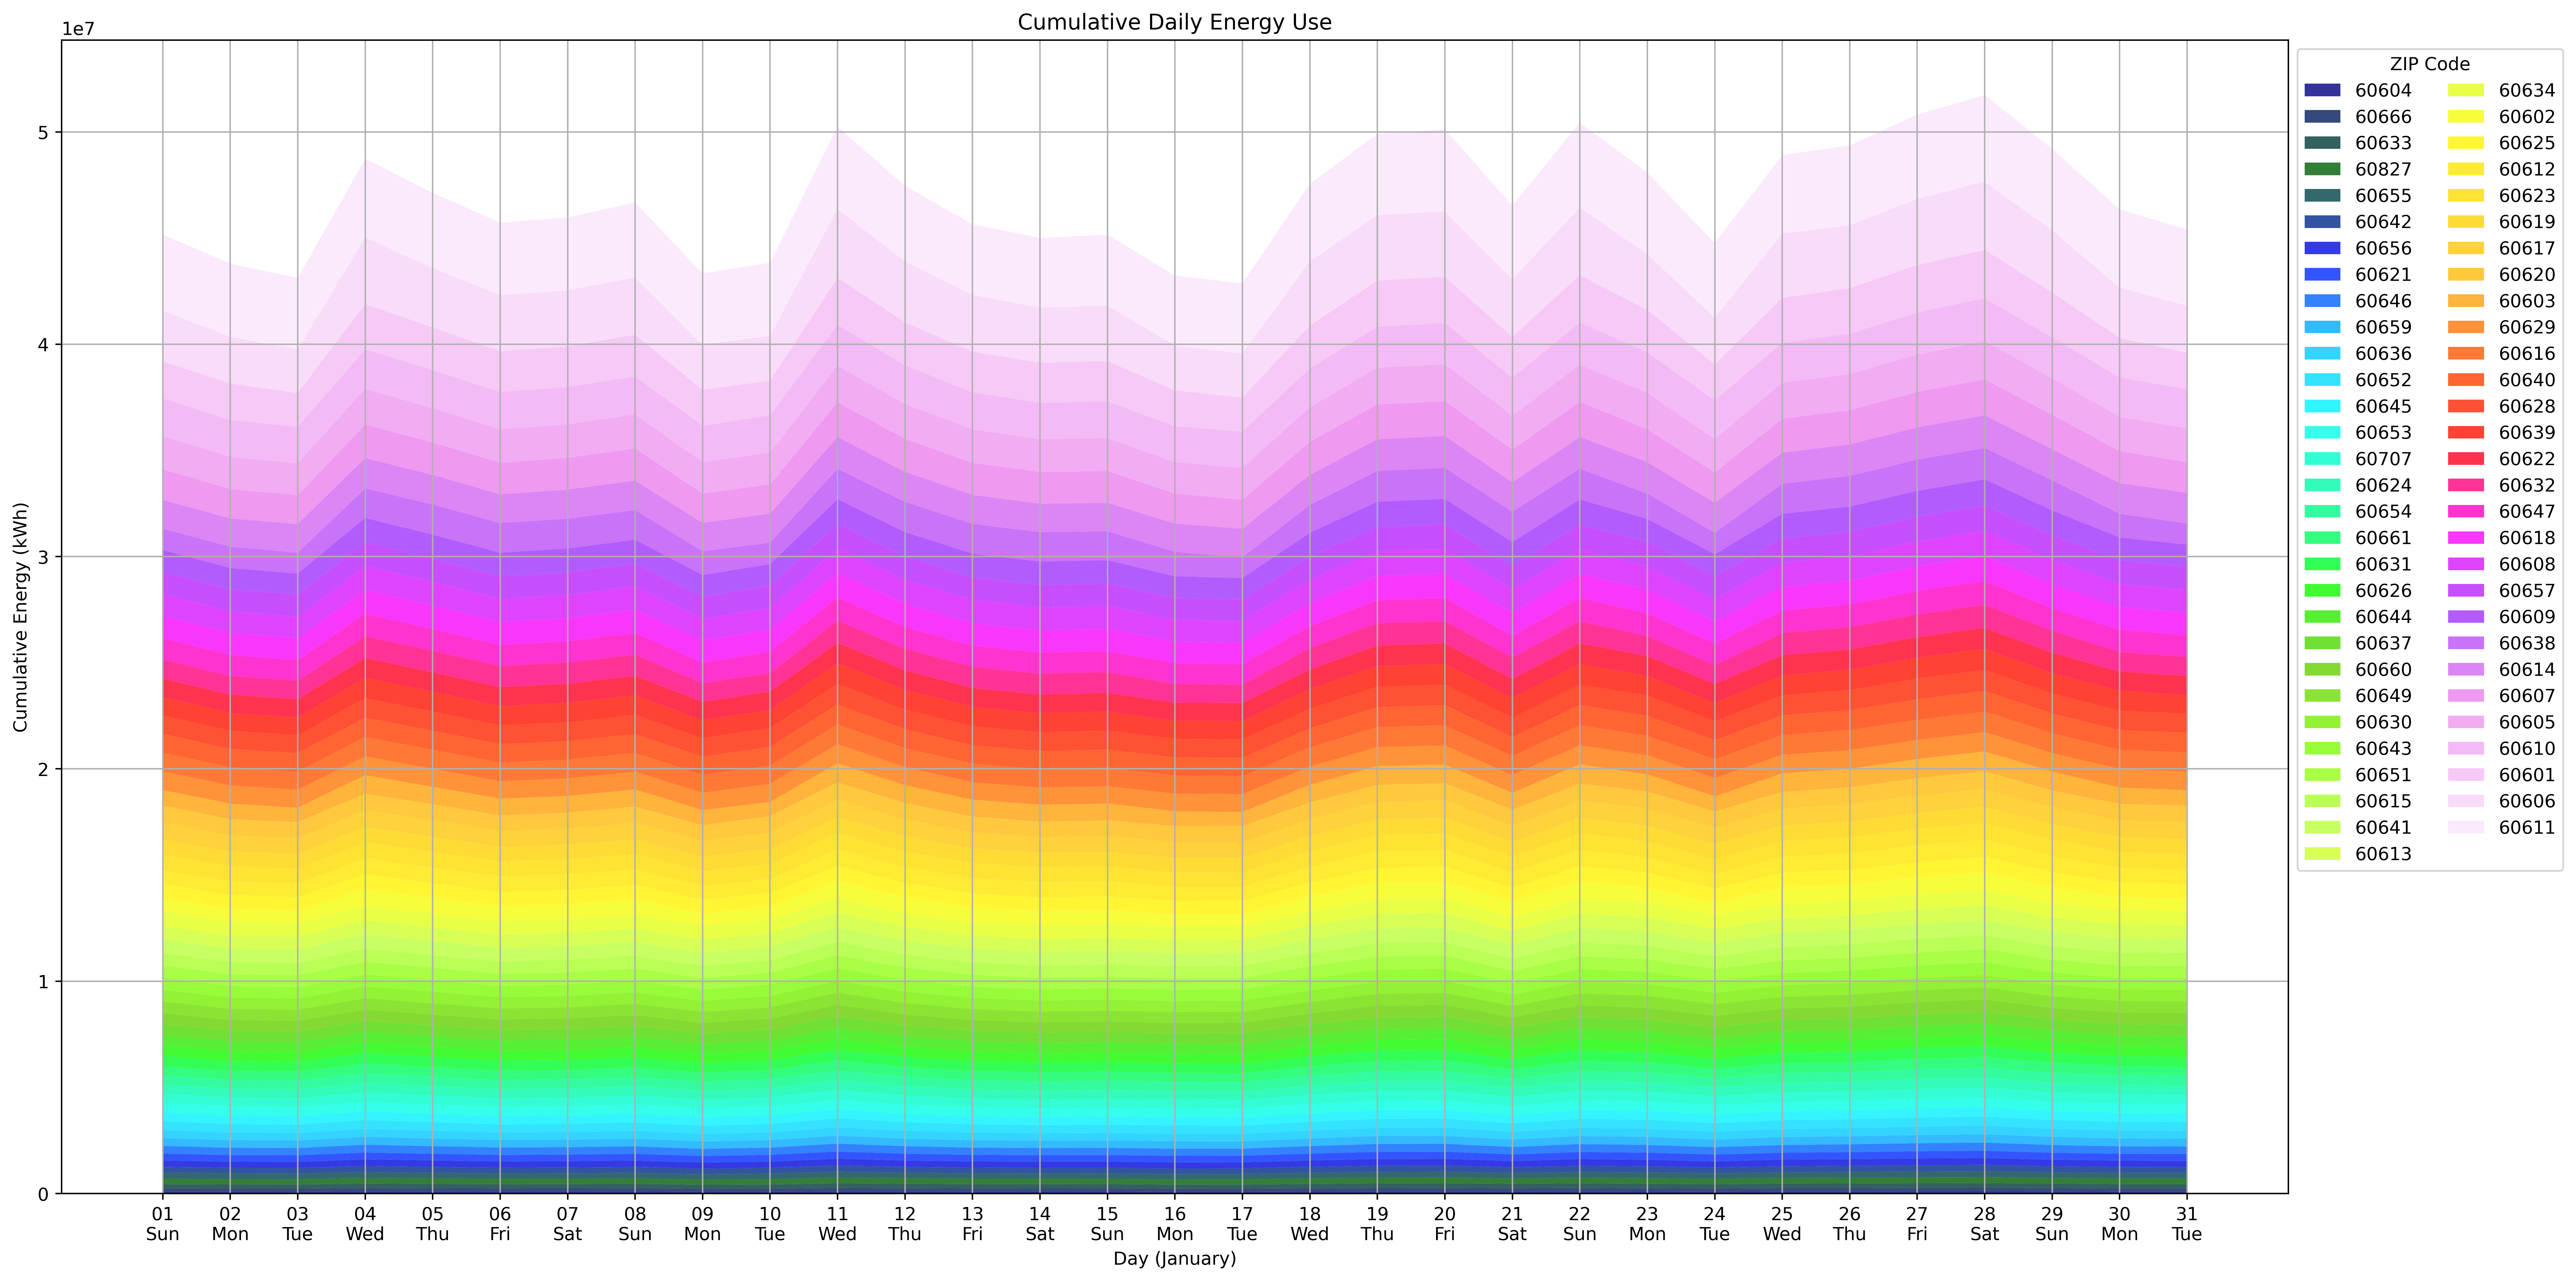

In [4]:
# Grouping by ZIP code and day to find total energy use per day
daily_energy = df.groupby(['day', 'ZIP_CODE'])['total_energy'].sum().unstack().fillna(0)

# Calculate the total energy use for each ZIP code
total_energy_per_zip = daily_energy.sum()

# Sort ZIP codes based on their total contributions
sorted_zips = total_energy_per_zip.sort_values(ascending=True).index

# Sort the DataFrame columns based on the sorted order
daily_energy_sorted = daily_energy[sorted_zips]

plt.figure(figsize=(20, 10), dpi=500)

cmap = plt.cm.gist_ncar

# Generate colors from the colormap
num_colors = len(daily_energy_sorted.columns)
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Plotting stacked line graph for daily energy use by ZIP code (sorted)
plt.stackplot(
    daily_energy_sorted.index,
    daily_energy_sorted.values.T,
    labels=daily_energy_sorted.columns,
    colors=colors,
    alpha=0.8
)

plt.xlabel('Day (January)')
plt.ylabel('Cumulative Energy (kWh)')
# Assuming 'daily_energy_use' and 'dates' are defined somewhere
plt.xticks(daily_energy_use['day'], [date.strftime('%d\n%a') for date in dates])
plt.title('Cumulative Daily Energy Use')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.0, 1), loc='upper left', ncols=2)
plt.grid(True)
plt.tight_layout()
plt.show()


### Corresponding Mapping

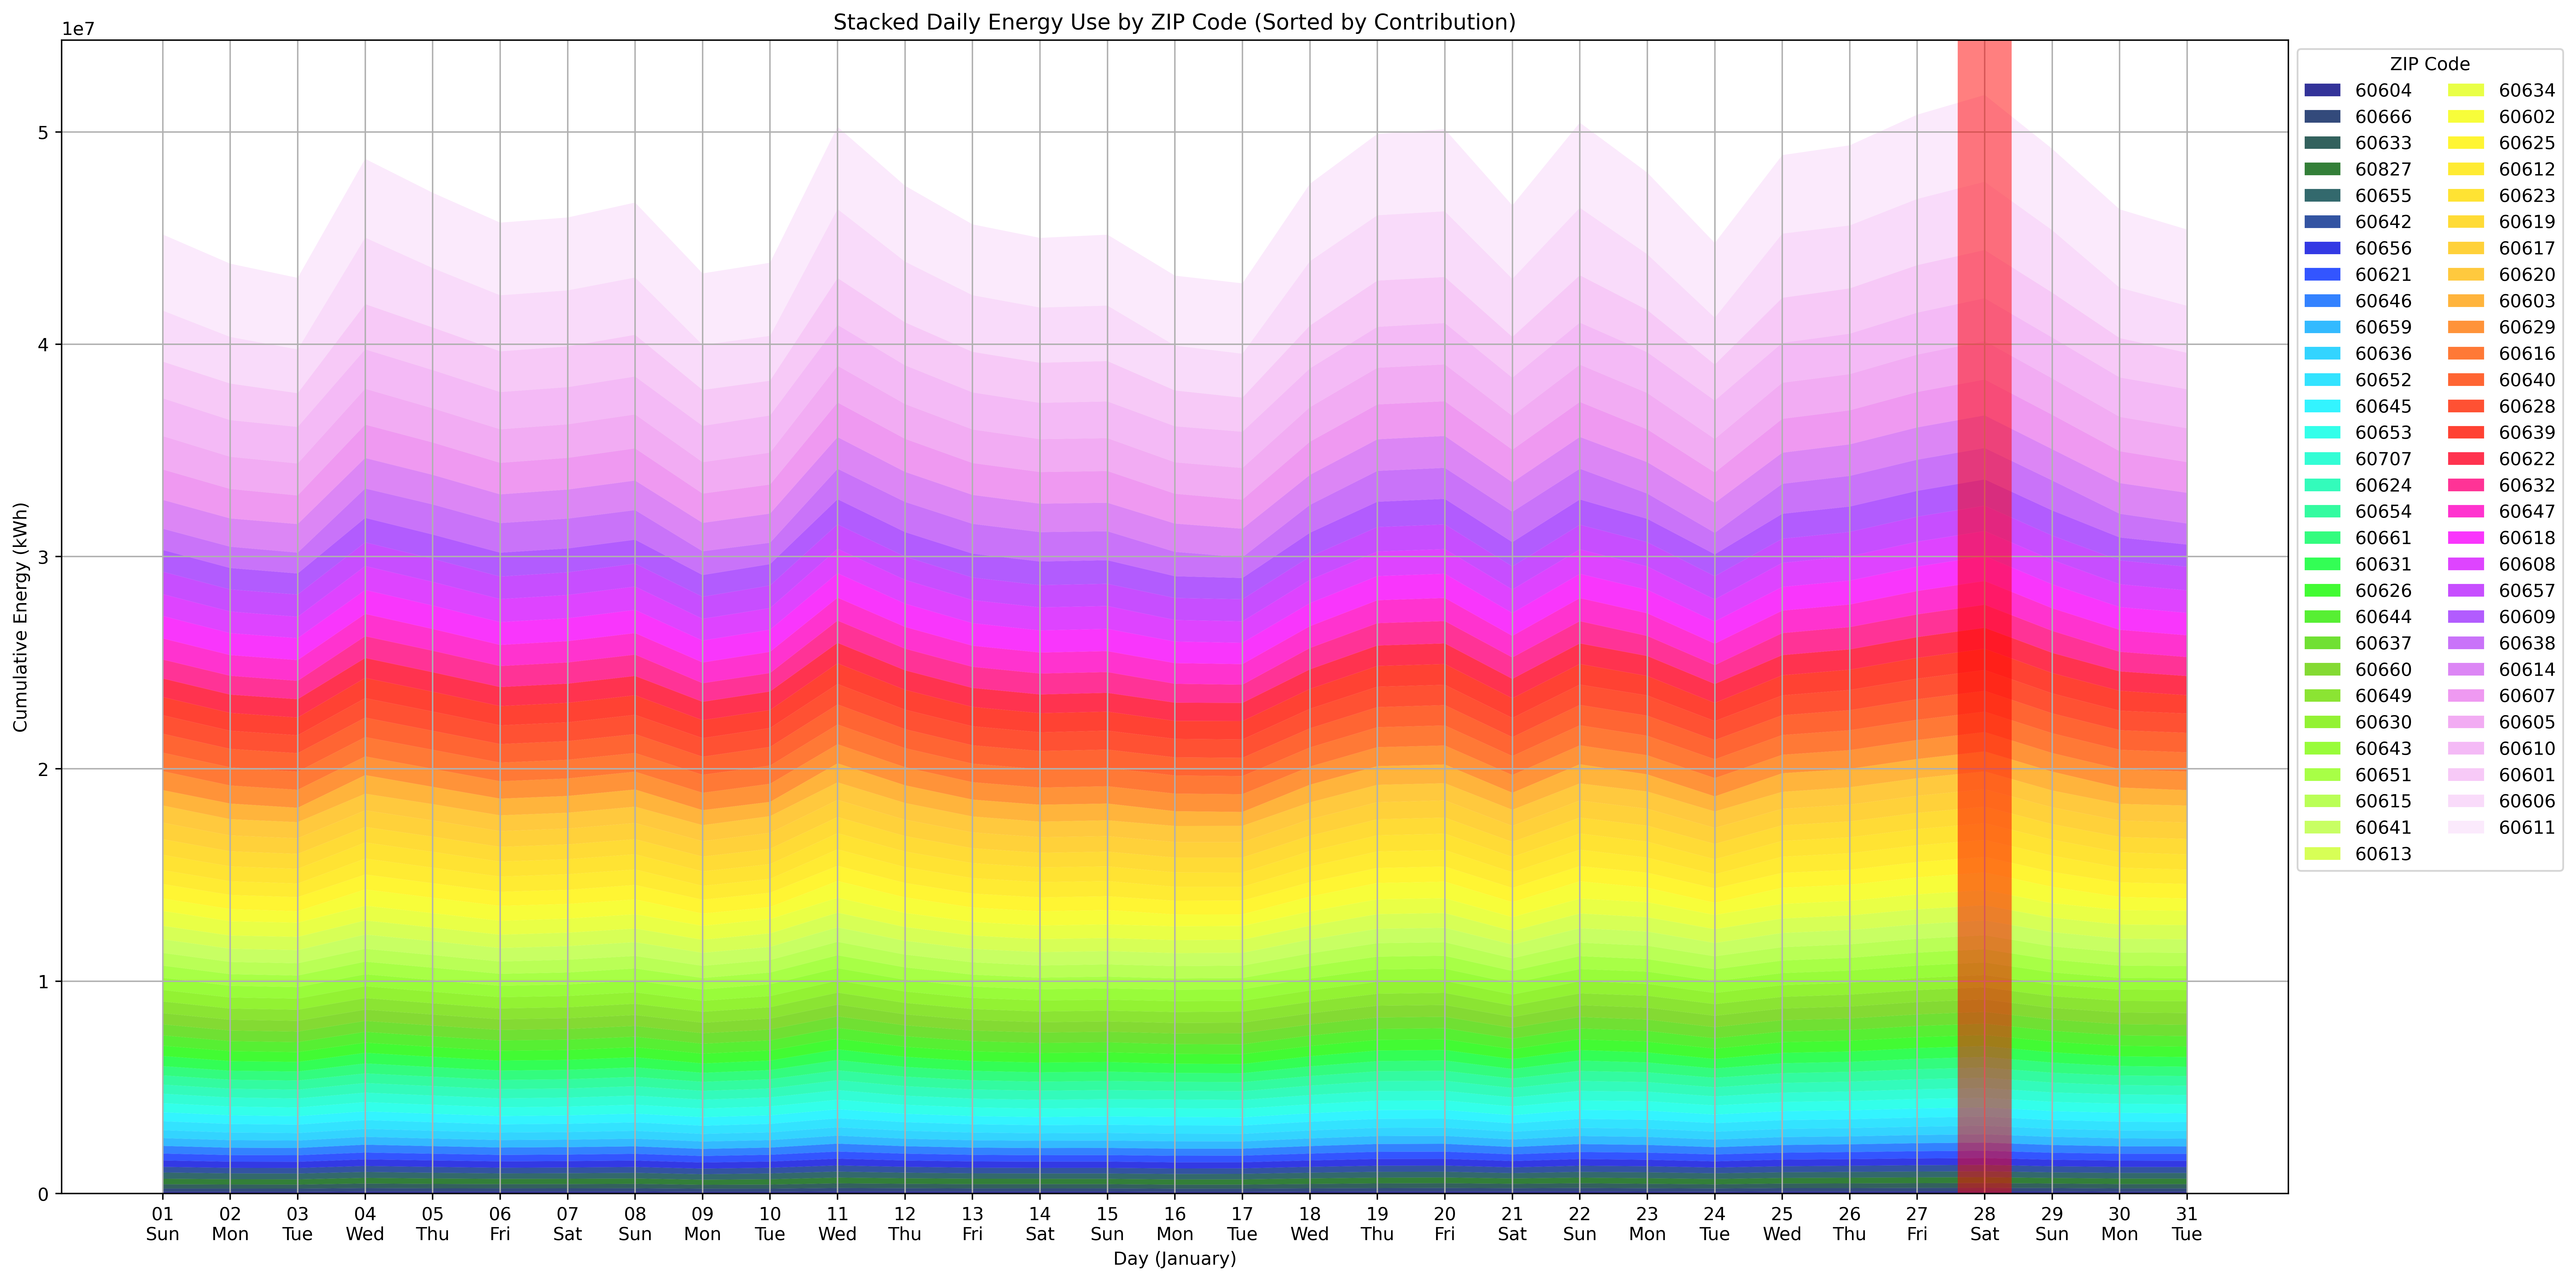

In [5]:
# Grouping by ZIP code and day to find total energy use per day
daily_energy = df.groupby(['day', 'ZIP_CODE'])['total_energy'].sum().unstack().fillna(0)

# Calculate the total energy use for each ZIP code
total_energy_per_zip = daily_energy.sum()

# Sort ZIP codes based on their total contributions
sorted_zips = total_energy_per_zip.sort_values(ascending=True).index

# Sort the DataFrame columns based on the sorted order
daily_energy_sorted = daily_energy[sorted_zips]

plt.figure(figsize=(20, 10), dpi=500)

cmap = plt.cm.gist_ncar

# Generate colors from the colormap
num_colors = len(daily_energy_sorted.columns)
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Plotting stacked line graph for daily energy use by ZIP code (sorted)
plt.stackplot(
    daily_energy_sorted.index,
    daily_energy_sorted.values.T,
    labels=daily_energy_sorted.columns,
    colors=colors,
    alpha=0.8
)

plt.axvline(28, color='red', linestyle='-', linewidth=30, alpha=0.5)

plt.xlabel('Day (January)')
plt.ylabel('Cumulative Energy (kWh)')
# Assuming 'daily_energy_use' and 'dates' are defined somewhere
plt.xticks(daily_energy_use['day'], [date.strftime('%d\n%a') for date in dates])
plt.title('Stacked Daily Energy Use by ZIP Code (Sorted by Contribution)')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.0, 1), loc='upper left', ncols=2)
plt.grid(True)
plt.tight_layout()
plt.show()


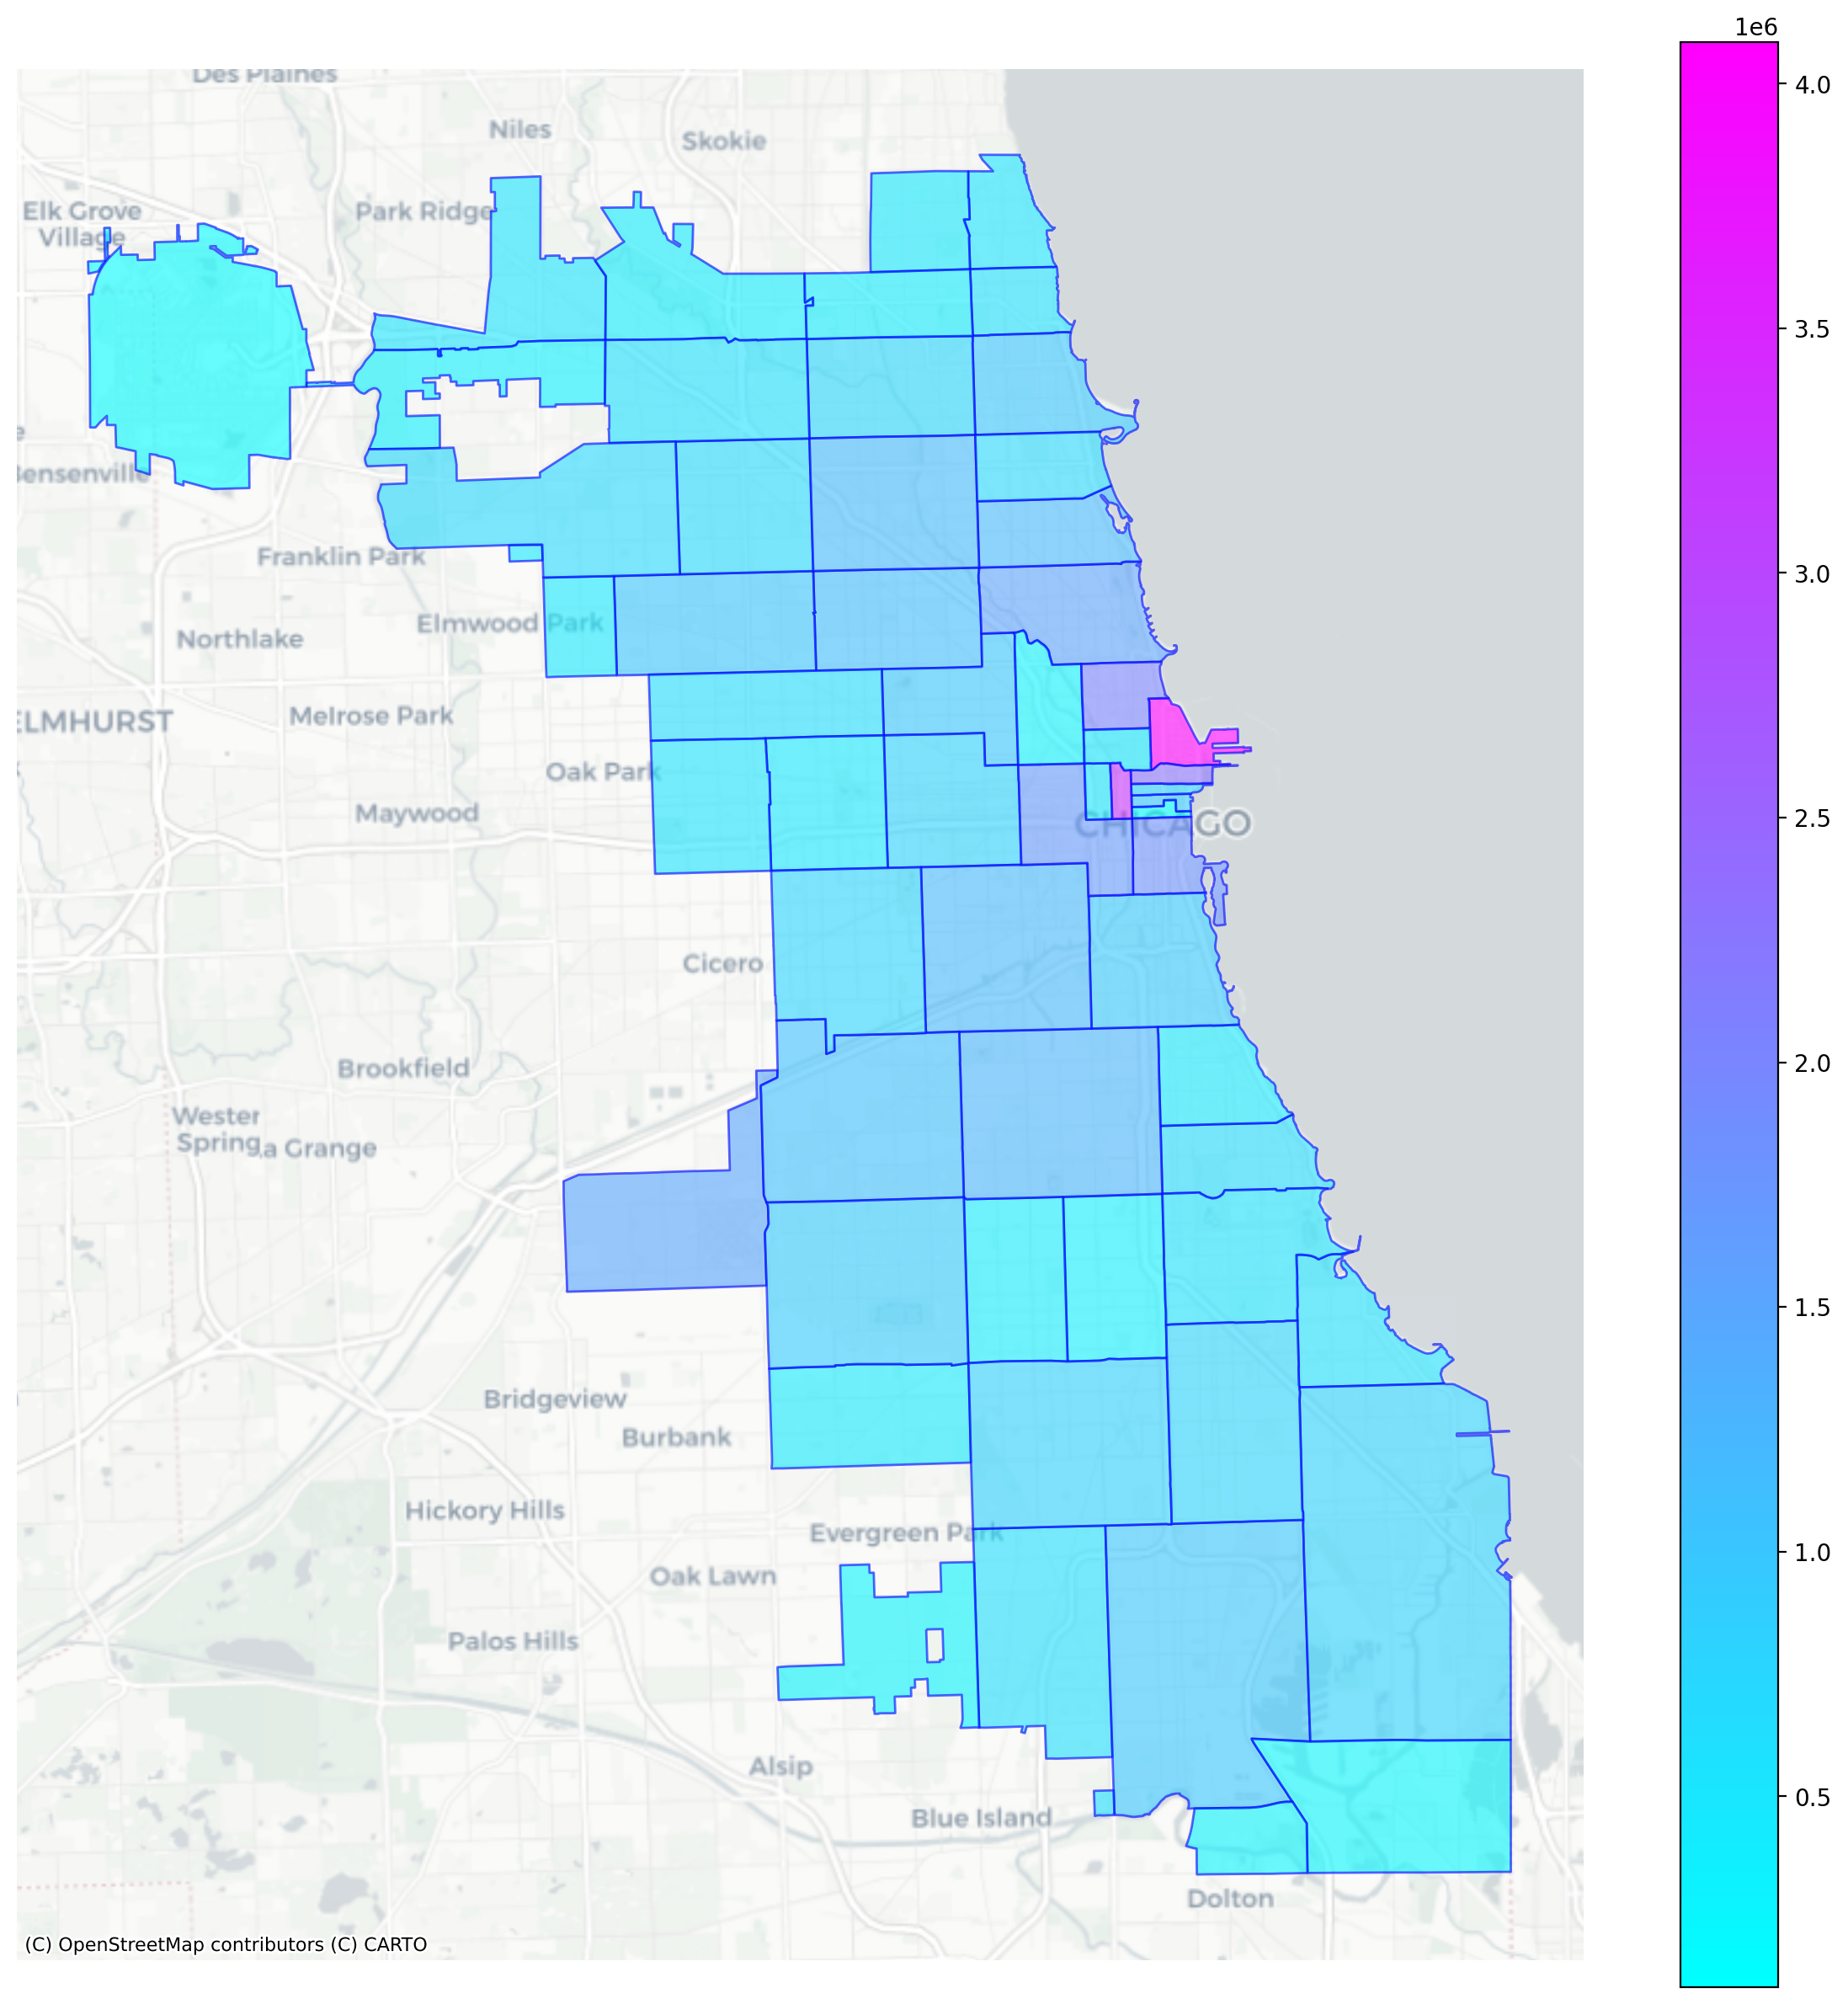

In [6]:
# get data use on the 28th
jan28th_use = daily_energy.T[28].reset_index(name='total_energy')
jan28th_use['ZIP_CODE'] = jan28th_use['ZIP_CODE'].astype(str)

# merge with gdf
gdf_jan28th = gdf.merge(jan28th_use, left_on='zip', right_on='ZIP_CODE', how='left').fillna({'total_energy': 0})

# plot
fig, ax = plt.subplots(figsize = (15,15), dpi = 200)

cmap = 'cool'

gdf_jan28th.plot(
    ax = ax,
    alpha=0.6,
    edgecolor='b',
    column="total_energy",
    legend = True,
    cmap=cmap
)

# add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.axis('off')

plt.show()

## Interval Usage on the 28th

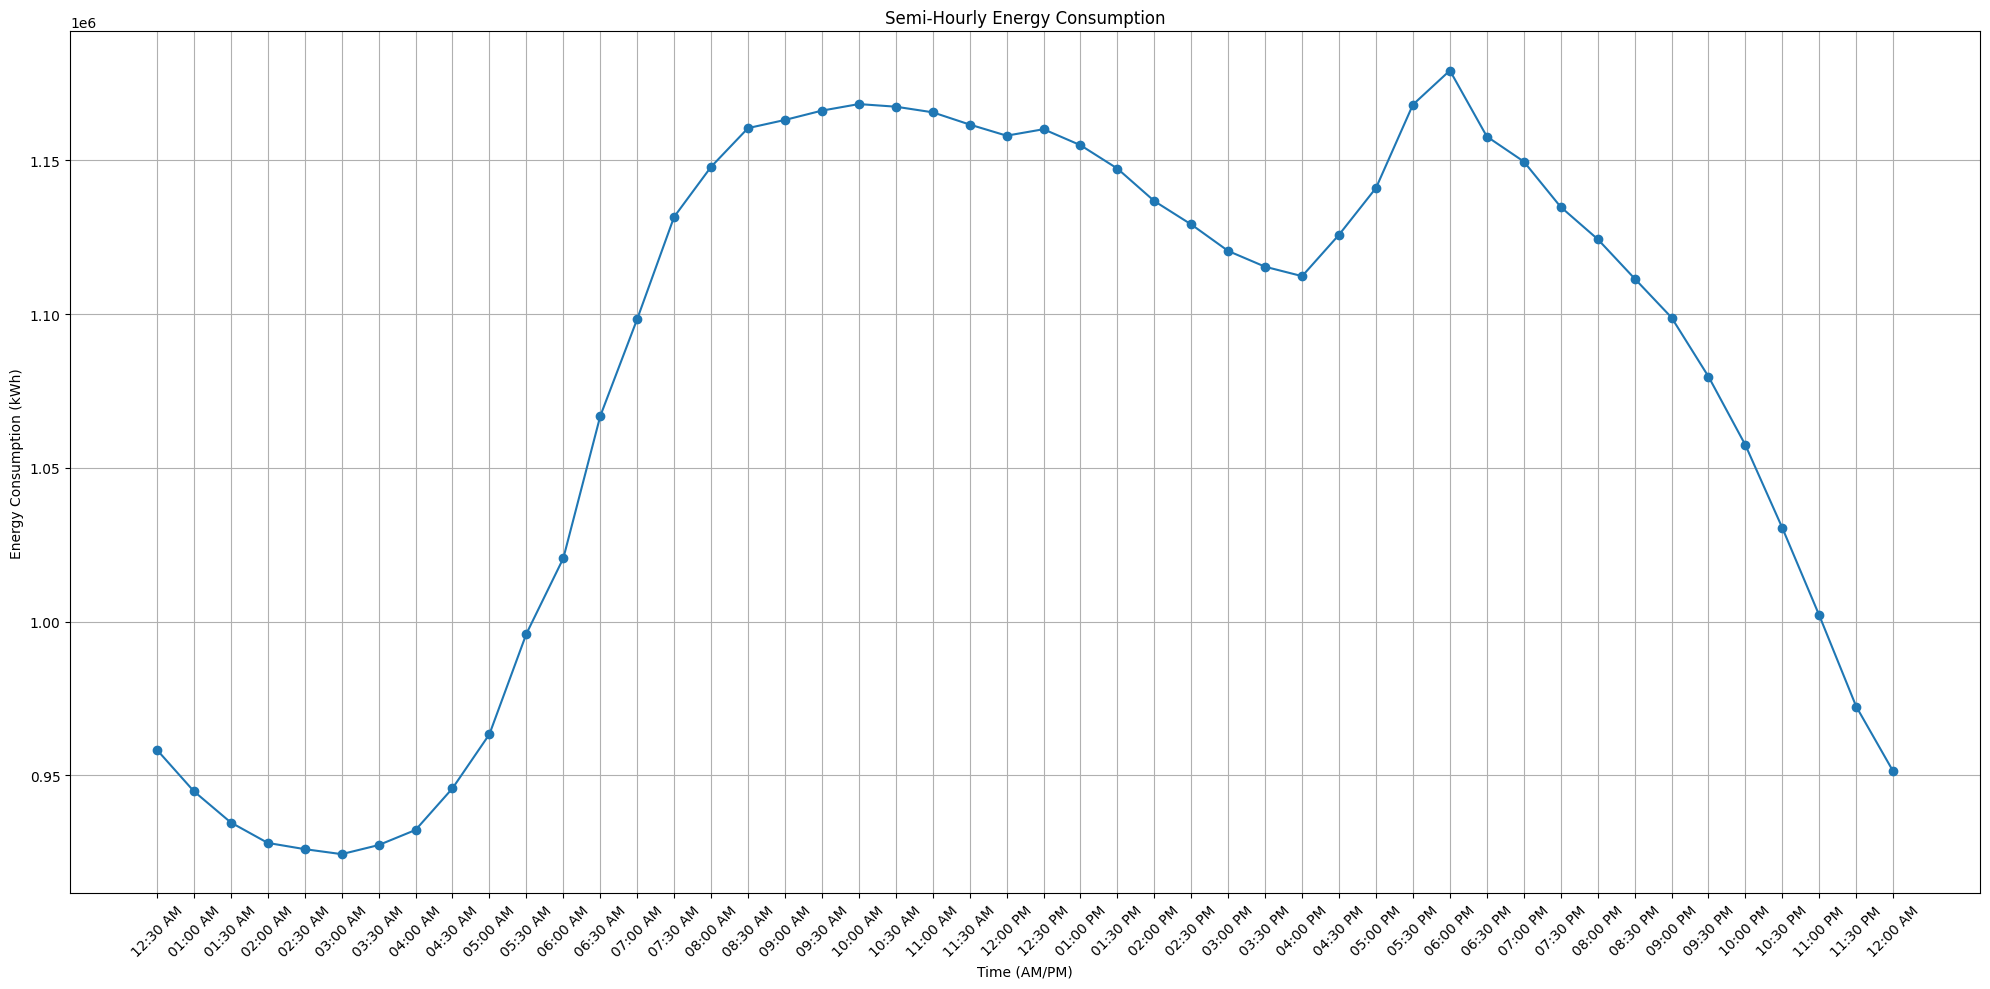

In [11]:
df_28 = df[df['day'] == 28]

df_28.to_csv('./data/results/processed/semi_hourly_28th.csv')

# Create a list of hourly times in military format
hourly_times_military = pd.date_range('00:30', periods=48, freq='30min')

# Convert military time to AM/PM format
hourly_times_ampm = hourly_times_military.strftime('%I:%M %p')

# Extracting the columns related to hourly energy consumption
hourly_columns = df_28.columns[df_28.columns.str.startswith('HR')]

# Calculating the mean across ZIP codes for each hour
sum_energy = df_28[hourly_columns].sum()

# Plotting the average hourly energy consumption
plt.figure(figsize=(20, 10))

plt.plot(hourly_times_ampm, sum_energy, marker='o')

plt.title('Semi-Hourly Energy Consumption')
plt.xlabel('Time (AM/PM)')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


## Interval Usage on the 28th, Stack Plot

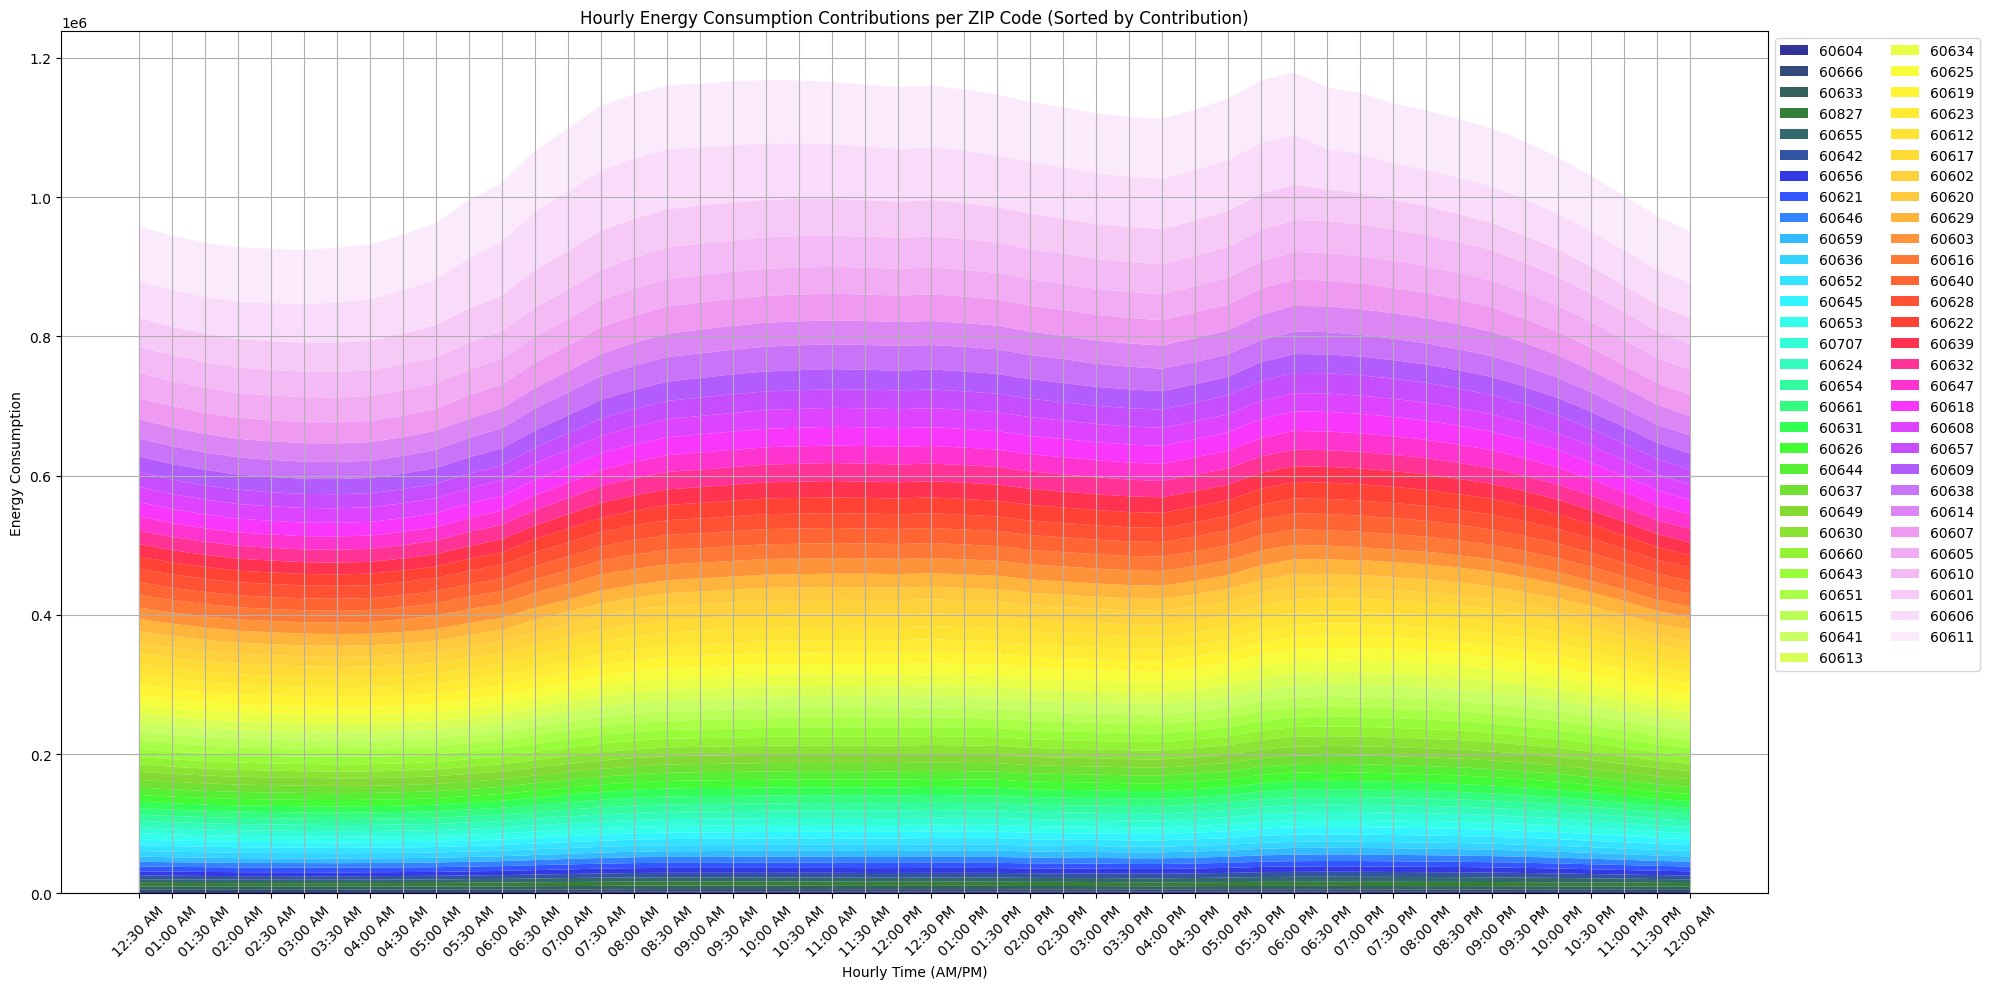

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_28 = df[df['day'] == 28]

# Extracting the columns related to hourly energy consumption
hourly_columns = df_28.columns[df_28.columns.str.startswith('HR')]

# Selecting data for the hourly columns for day 28
hourly_data = df_28[hourly_columns].values

# Calculating total contribution per ZIP code
total_contribution = np.sum(hourly_data, axis=1)

# Sort by contribution
sorted_indices = np.argsort(total_contribution)

# Sort ZIP codes and hourly data by contribution
sorted_zip_codes = df_28.iloc[sorted_indices]['ZIP_CODE']
sorted_hourly_data = hourly_data[sorted_indices]

# Checking the common length
common_length = min(len(hourly_times_ampm), sorted_hourly_data.shape[1])

plt.figure(figsize=(20, 10))

cmap = plt.cm.gist_ncar

# Generate colors from the colormap
num_colors = len(sorted_zip_codes)
colors = [cmap(i / num_colors) for i in range(num_colors)]

plt.stackplot(hourly_times_ampm[:common_length], sorted_hourly_data[:, :common_length], labels=sorted_zip_codes, colors=colors, alpha=0.8)

plt.title('Hourly Energy Consumption Contributions per ZIP Code (Sorted by Contribution)')
plt.xlabel('Hourly Time (AM/PM)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncols=2)
plt.grid()
plt.tight_layout()
plt.show()

## Interval Usage, Jan 24 to Jan 31

In [9]:
dataframes = []

for day in range(25, 32):
    df_day = df[df['day'] == day]

    hourly_columns = df_day.columns[df_day.columns.str.startswith('HR')]
    hourly_data = df_day[hourly_columns].values
    total_contribution = np.sum(hourly_data, axis=1)
    sorted_indices = np.argsort(total_contribution)
    sorted_zip_codes = df_day.iloc[sorted_indices]['ZIP_CODE']
    sorted_hourly_data = hourly_data[sorted_indices]

    common_length = min(len(hourly_times_ampm), sorted_hourly_data.shape[1])

    day_str = f"2021-01-{day:02d}"

    plotted_data = {'timestamp': [f"{day_str} {time}" for time in hourly_times_ampm[:common_length]]}
    for i, zip_code in enumerate(sorted_zip_codes):
        plotted_data[zip_code] = sorted_hourly_data[i, :common_length]

    plotted_df = pd.DataFrame(plotted_data)
    dataframes.append(plotted_df)  # Store DataFrame for the day

# Concatenate DataFrames for days 24 to 31 row-wise
df_combined_days = pd.concat(dataframes, ignore_index=True)

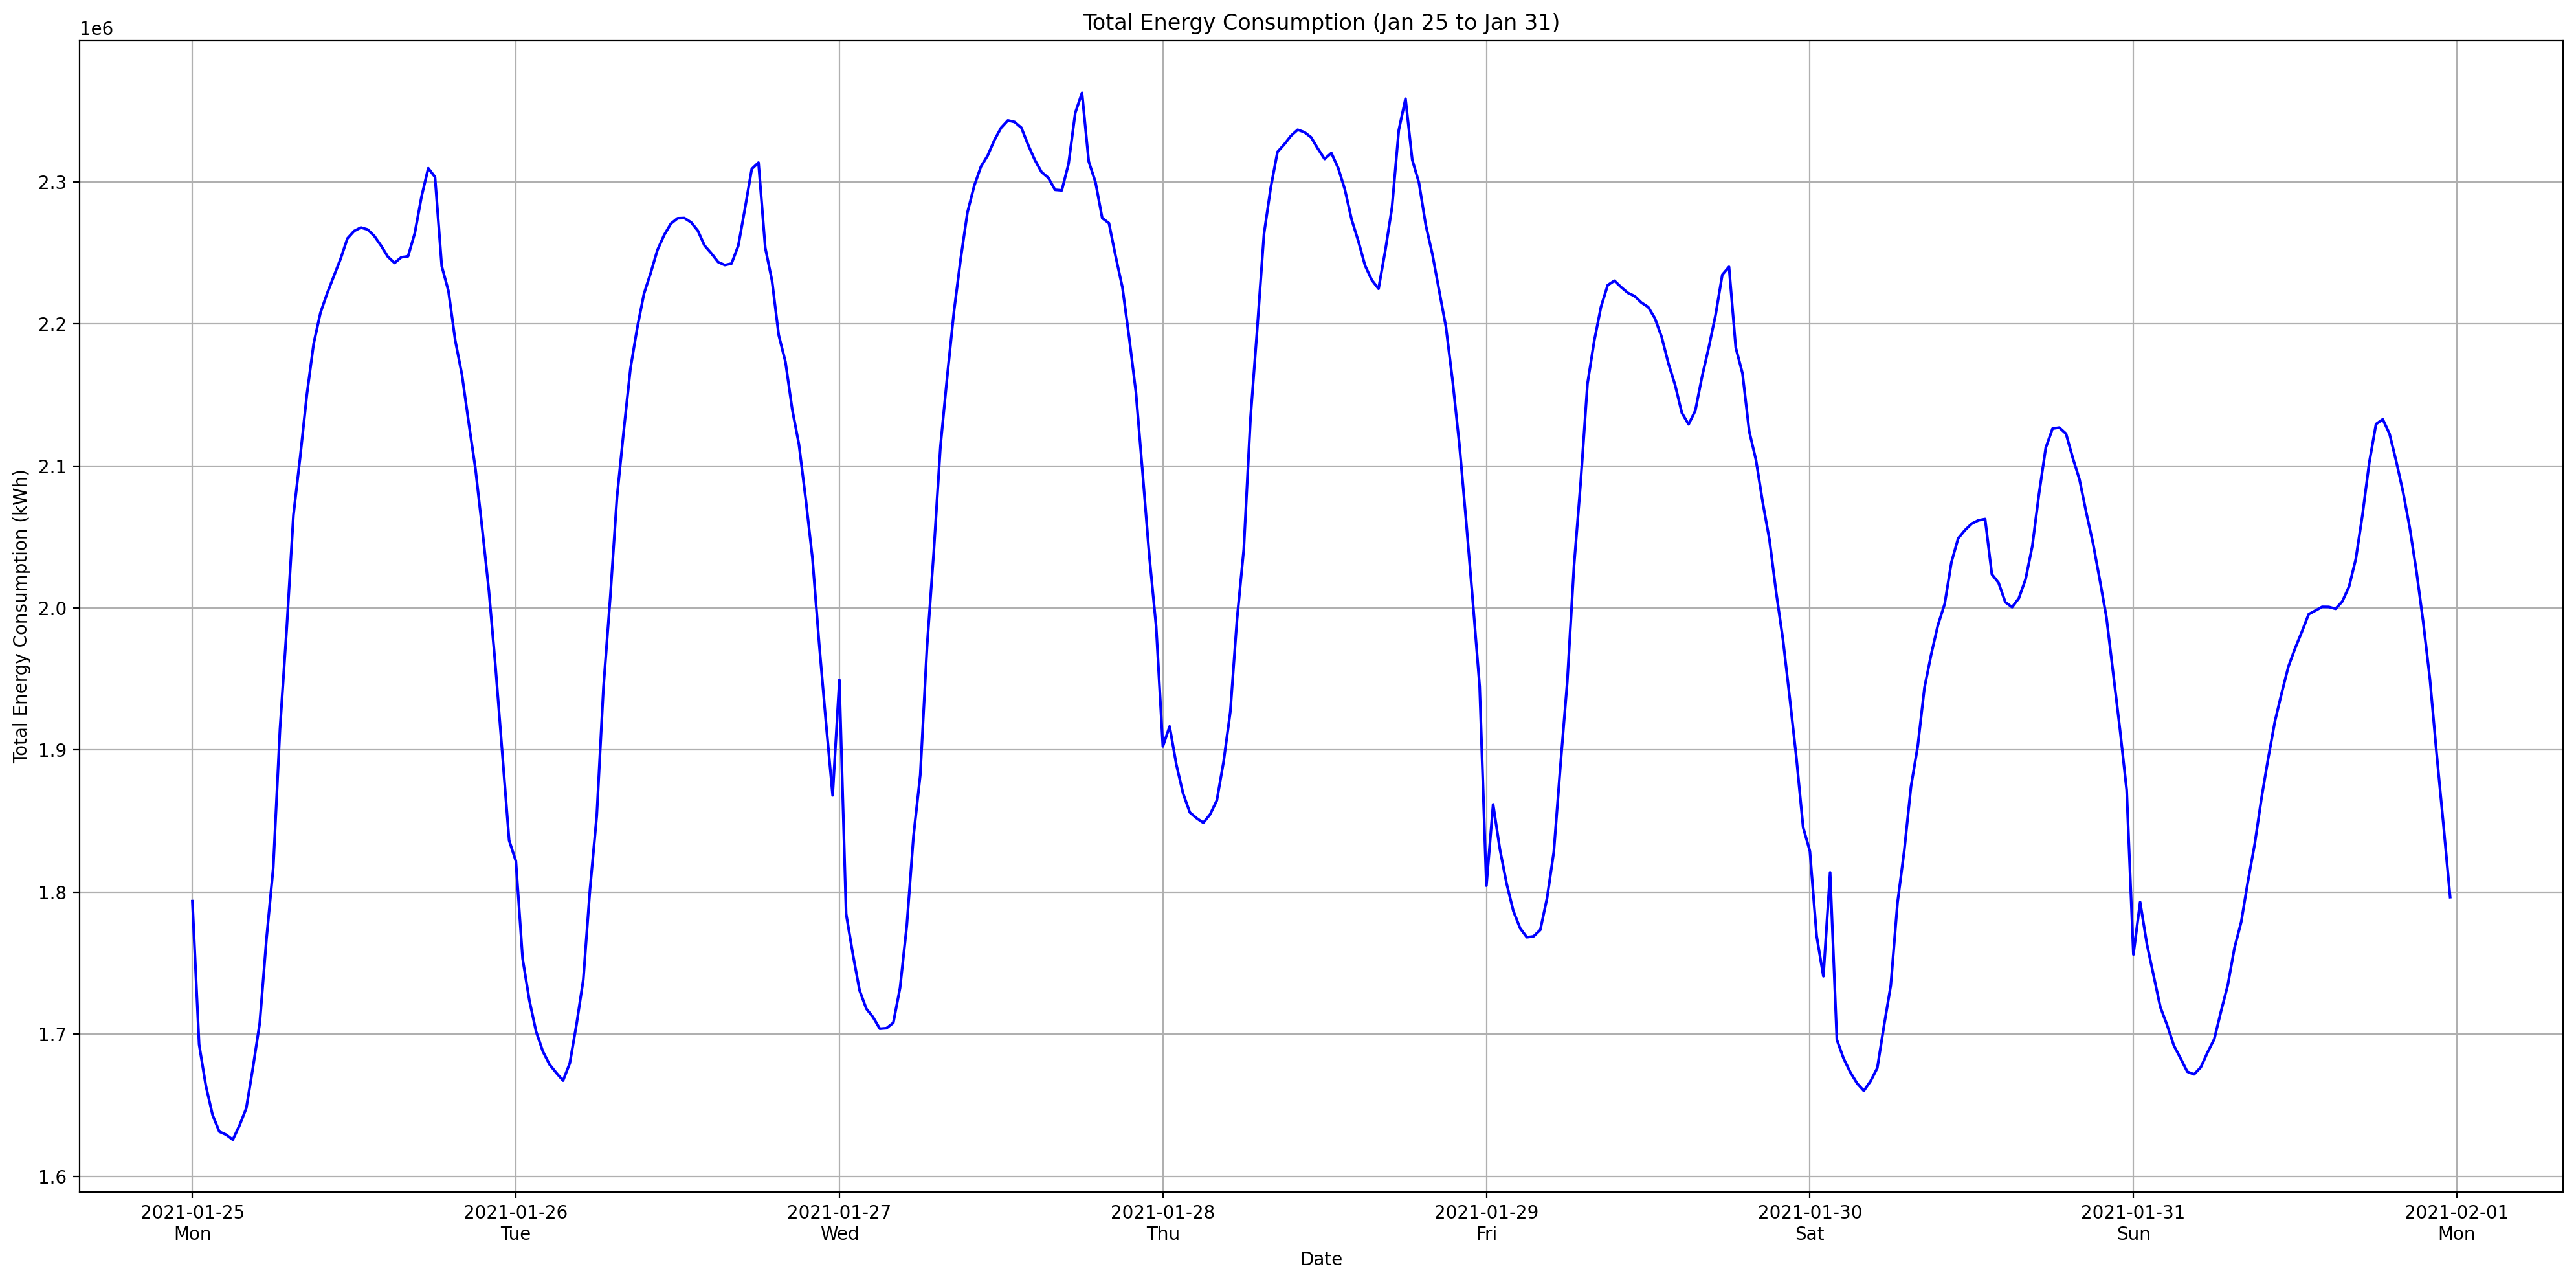

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert timestamp strings to datetime objects
df_combined_days['timestamp'] = pd.to_datetime(df_combined_days['timestamp'])

# Remove duplicates based on 'timestamp'
df_combined_days = df_combined_days.drop_duplicates(subset='timestamp', keep='first')

# Sort the DataFrame by 'timestamp'
df_combined_days = df_combined_days.sort_values('timestamp')

df_combined_days['Total_Energy'] = df_combined_days.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(20, 10), dpi=200)
plt.plot(df_combined_days['timestamp'], df_combined_days['Total_Energy'], color='blue')

# Set major ticks as days and format to show both date and day of the week
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%a'))

plt.xlabel('Date')
plt.ylabel('Total Energy Consumption (kWh)')
plt.title('Total Energy Consumption (Jan 25 to Jan 31)')
plt.xticks()
plt.tight_layout()
plt.grid()
plt.show()

df_combined_days.to_csv("./data/results/processed/semi_hourly_time_series.csv")
